# Matrix Methods for PageRank: Theoretical Foundations and Computational Applications

This notebook provides a computational study of the PageRank algorithm. By simulating small web graphs and progressively modifying their structure through the addition of pages with controlled link patterns, we investigate how such changes influence the PageRank vector and alter the resulting ranking of pages.

The notebook provides reproducible Python implementations, including:

- a modular routine to generate $\mathbf{M}$ and the initial vector $\mathbf{v}_0$ from any given link matrix $\mathbf{A}$.

- a power method for efficiently computing the PageRank vector.

- interactive plots that illustrate the impact of varying the damping factor $m$.


**Reference:** K. Bryan, T. L. Leise, *The \$25,000,000,000 Eigenvector: The Linear Algebra behind Google*, SIAM Review, 2006.  

---

## Exercise 11
Consider again the web in Figure 2.1, with the addition of a page 5 that links to page 3, where page 3 also links to page 5. Calculate the new ranking by finding the eigenvector of $\mathbf{M}$ (corresponding to $\lambda=1$) that has positive components summing to one. Use $m=0.15$.

---

### Libraries Import and Functions Definitions

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ipywidgets import interact, FloatSlider
import networkx as nx
from matplotlib.animation import FuncAnimation


def compute_M_matrix(A,m):
    n=A.shape[0]
    S = np.ones((n, n)) / n
    M = (1 - m) * A + m * S
    v0 = np.ones(n)
    v0 /= np.linalg.norm(v0, 2)

    return M, v0
    

def pagerank_power_method_classic(M,v, max_iter=1000, tol=1e-10):
    lam_old = None
    lambdas = []
    errors = []
    
    for _ in range(max_iter):
        w = M @ v
        lam = v @ w
        lambdas.append(lam)
        v = w / np.linalg.norm(w, 2)
        
        if lam_old is None:
            errors.append(np.nan)
        else:
            error = abs(lam - lam_old)
            errors.append(error)
            if error < tol * abs(lam):
                break      
        lam_old = lam
        
    v_fin = v / v.sum()
    return v_fin, np.array(lambdas), np.array(errors)

### 4-Pages Web PageRank Computation

In [2]:
A4 = np.array([
    [0,   0,   1/2, 1/2],
    [1/3, 0,   0,   0],
    [1/3, 1/2, 0,   1/2],
    [1/3, 1/2, 0,   0]
])

def plot_pagerank_classic(m):
    M,v0=compute_M_matrix(A4,m)
    v,_,_ = pagerank_power_method_classic(M,v0)
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, 5), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('Rank')
    plt.title(f'PageRank ($m$ = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_classic,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 5-Pages Web PageRank Computation

In [3]:
A5 = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
], dtype=float)

def plot_pagerank_classic(m):
    M,v0=compute_M_matrix(A5,m)
    v,_,_ = pagerank_power_method_classic(M,v0)
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, 6), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('Rank')
    plt.title(f'PageRank ($m$ = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

interact(plot_pagerank_classic,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### Rayleigh Quotient and Error Evolutions

In [4]:
def plot_rayleigh_and_error(m):
    M,v0=compute_M_matrix(A5,m)
    v,lambdas,errors = pagerank_power_method_classic(M,v0)

    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].plot(lambdas, marker='o')
    ax[0].set_title("Rayleigh Quotient Evolution")
    ax[0].set_xlabel("Iteration")
    
    mask = np.isfinite(errors)
    ax[1].plot(np.where(mask)[0], errors[mask], marker='o')
    ax[1].set_yscale("log")
    ax[1].set_title("|λ(k+1) − λ(k)| (log scale)")
    ax[1].set_xlabel("Iteration")
    plt.tight_layout() 
    plt.show()

interact(plot_rayleigh_and_error,m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 4-Pages Web Graph Plot

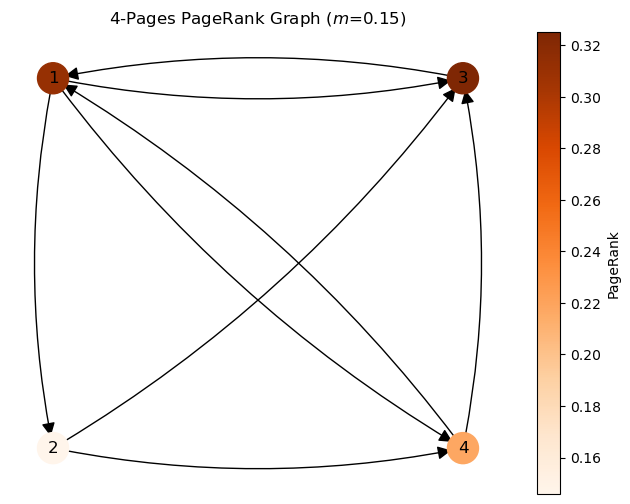

In [5]:
M,v0=compute_M_matrix(A4,0.15)
v,_,_ = pagerank_power_method_classic(M,v0)

G = nx.DiGraph()
G.add_nodes_from(range(1,5))

for i in range(4):
    for j in range(4):
        if A4[i,j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),    
    4: (1, 0),  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  

fig, ax = plt.subplots(figsize=(8,6))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20,ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'4-Pages PageRank Graph ($m$={0.15})')
ax.axis('off')  
plt.show()

### 5-Pages Web Graph Plot

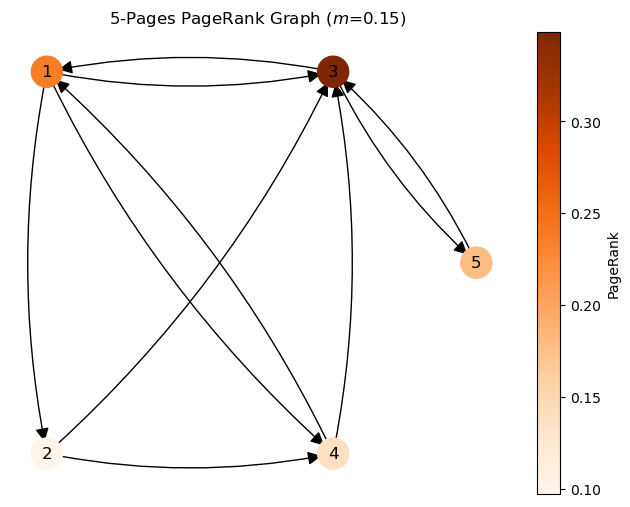

In [6]:
M,v0=compute_M_matrix(A5,0.15)
v,_,_ = pagerank_power_method_classic(M,v0)

G = nx.DiGraph()
G.add_nodes_from(range(1,5))

for i in range(5):
    for j in range(5):
        if A5[i,j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),     
    3: (1, 1),     
    2: (0, 0),     
    4: (1, 0),     
    5: (1.5, 0.5)  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  

fig, ax = plt.subplots(figsize=(8,6))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20,ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'5-Pages PageRank Graph ($m$={0.15})')
ax.axis('off') 
plt.show()

### 5-Pages Web PageRank Sensitivity with respect to $m$

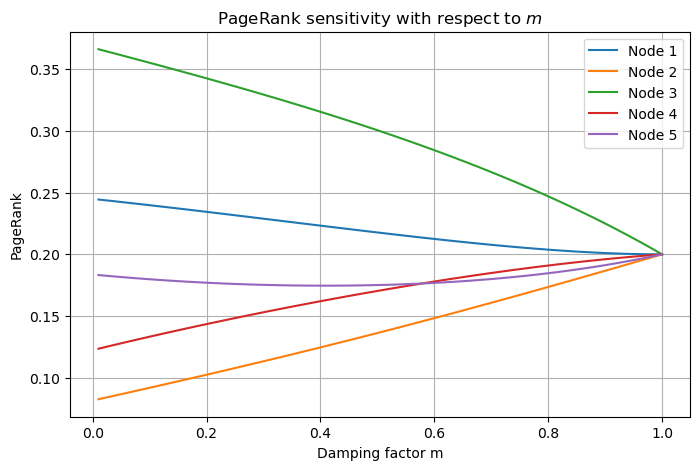

In [7]:
m_values = np.linspace(0.01, 1, 50)
pagerank_vs_m = []

for m_val in m_values:
    M,v0=compute_M_matrix(A5,m_val)
    pr,_,_ = pagerank_power_method_classic(M,v0)
    pagerank_vs_m.append(pr)

pagerank_vs_m = np.array(pagerank_vs_m)

plt.figure(figsize=(8, 5))
for i in range(5):
    plt.plot(m_values, pagerank_vs_m[:, i], label=f'Node {i+1}')

plt.xlabel('Damping factor m')
plt.ylabel('PageRank')
plt.title('PageRank sensitivity with respect to $m$')
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()

### 4-Pages vs 5-Pages Web PageRank Comparison - Part 1

In [8]:
def plot_pagerank_comparison(m):
    nodes = ['1','2','3','4','5']
    M5, v0_5 = compute_M_matrix(A5, m)   
    v5, _, _ = pagerank_power_method_classic(M5, v0_5)
    M4, v0_4 = compute_M_matrix(A4, m)   
    v4, _, _ = pagerank_power_method_classic(M4, v0_4)
    
    x = np.arange(len(nodes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.bar(x - width/2, v5, width, label='5-Pages Web')
    ax.bar(x + width/2, np.append(v4, 0), width, label='4-Pages Web')

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_xlabel('Page')
    ax.set_ylabel('PageRank')
    ax.set_title(f'PageRank Comparison: 4-Pages Web vs 5-Pages Web ($m$={m:.2f})')
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 0.5)
    
    for i, (r1, r2) in enumerate(zip(v5, np.append(v4, 0))):
        ax.text(i - width/2, r1 + 0.01, f"{r1:.3f}", ha='center', fontsize=9)
        if r2 > 0:
            ax.text(i + width/2, r2 + 0.01, f"{r2:.3f}", ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_comparison, m=FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, min=0.01, step=0.01), Output()), _dom_…

### 4-Pages vs 5-Pages Web PageRank Comparison - Part 2

In [9]:
def plot_pagerank_difference_relative(m=0.15):
    nodes = ['1','2','3','4']    
    M5,v0_5 = compute_M_matrix(A5, m)   
    v5,_,_ = pagerank_power_method_classic(M5, v0_5)
    M4,v0_4 = compute_M_matrix(A4, m)   
    v4,_,_ = pagerank_power_method_classic(M4, v0_4)
    v5_trim = v5[:4]
    diff_rel = ((v5_trim - v4) / v4) * 100
    
    x = np.arange(len(nodes))
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, diff_rel, width=0.3, color='green', alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_title(f'Page 5 Impact on 4-Pages Web PageRank  ($m$={m:.2f})', fontsize=13)
    ax.set_xlabel('Page')
    ax.set_ylabel('Relative Difference (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    ax.bar_label(bars, labels=[f"{val:+.1f}%" for val in diff_rel], label_type='center', fontsize=10, padding=3)

    plt.tight_layout()
    plt.show()

interact(plot_pagerank_difference_relative, m=FloatSlider(value=0.15, min=0.0, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

---
## Esercise 12
Add a sixth page that links to every page of the web in the previous exercise, but to which no other page links. Rank the pages using $\mathbf{A}$, then using $\mathbf{M}$ with $m=0.15$, and compare the results.

---

### 6-Pages Web A vs M PageRank Comparison - Part 1

In [10]:
A6 = np.array([
    [0,   0,   1/2, 1/2, 0, 1/5],
    [1/3, 0,   0,   0,   0, 1/5],
    [1/3, 1/2, 0,   1/2, 1, 1/5],
    [1/3, 1/2, 0,   0,   0, 1/5],
    [0,   0,   1/2, 0,   0, 1/5],
    [0,   0,   0,   0,   0,   0]
], dtype=float)


def plot_pagerank_comparison(m):
    M, v0 = compute_M_matrix(A6, m)
    v_m, _, _ = pagerank_power_method_classic(M, v0)
    
    n6 = A6.shape[0]
    v0_a6 = np.ones(n6)
    v0_a6 /= np.linalg.norm(v0_a6, 2)
    v_a6, _, _ = pagerank_power_method_classic(A6, v0_a6)
    
    pages = np.arange(1, 7)
    bar_width = 0.35
    plt.figure(figsize=(9, 6))
    plt.bar(pages - bar_width/2, v_a6, width=bar_width, label='A')
    plt.bar(pages + bar_width/2, v_m, width=bar_width, label=f'M ($m$={m:.2f})')
    plt.ylim(0, 0.5)
    plt.xlabel('Page')
    plt.ylabel('PageRank')
    plt.title('6-Pages web PageRank Comparison: A vs M')
    plt.xticks(pages)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout()

    for i, (r1, r2) in enumerate(zip(v_a6, v_m)):
        plt.text(i + 1 - bar_width/2, r1 + 0.01, f"{r1:.3f}", ha='center', fontsize=9)
        plt.text(i + 1 + bar_width/2, r2 + 0.01, f"{r2:.3f}", ha='center', fontsize=9)
        
    plt.show()

interact(plot_pagerank_comparison, m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 6-Pages Web A vs M PageRank Comparison - Part 2

In [11]:
def plot_pagerank_difference_relative_five(m=0.15):
    nodes = ['1', '2', '3', '4', '5']
    M, v0_M = compute_M_matrix(A6, m)
    v_M, _, _ = pagerank_power_method_classic(M, v0_M)
    n = A6.shape[0]
    v0_A6 = np.ones(n) / np.sqrt(n)
    v_A6, _, _ = pagerank_power_method_classic(A6, v0_A6)
    v_M_5 = v_M[:5]
    v_A6_5 = v_A6[:5]
    diff_rel = 100 * (v_M_5 - v_A6_5) / v_M_5

    x = np.arange(len(nodes))
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, diff_rel, width=0.3, color='darkorange', alpha=0.85)

    ax.set_xticks(x)
    ax.set_xticklabels([f'Page {i}' for i in nodes], fontsize=11)
    ax.set_title(f'Relative PageRank Difference A vs M ($m$={m:.2f})', fontsize=13, pad=15)
    ax.set_xlabel('Page', fontsize=12)
    ax.set_ylabel('Relative Difference (%)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    ax.bar_label(bars, labels=[f"{val:+.1f}%" for val in diff_rel], label_type='center', fontsize=10, padding=3)
    plt.tight_layout()
    plt.show()

interact(plot_pagerank_difference_relative_five, m=FloatSlider(value=0.15, min=0.0, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

### 6-Pages Web Graph Plot

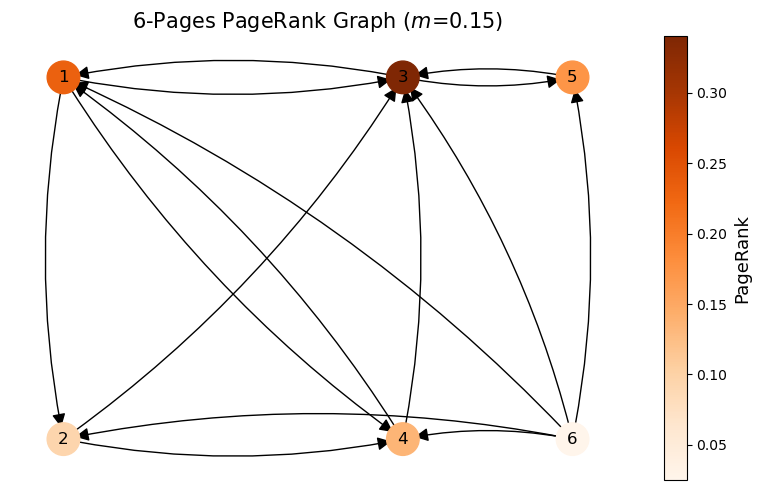

In [12]:
M, v0 = compute_M_matrix(A6, 0.15)
v, _, _ = pagerank_power_method_classic(M, v0)

G = nx.DiGraph()
G.add_nodes_from(range(1, 7)) 

for i in range(6):
    for j in range(6):
        if A6[i, j] > 0:
            G.add_edge(j+1, i+1)

pos = {
    1: (0, 1),
    3: (1, 1),
    2: (0, 0),
    4: (1, 0),
    5: (1.5, 1),
    6: (1.5, 0)  
}

norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))

fig, ax = plt.subplots(figsize=(8, 5))

nx.draw_networkx_nodes(G, pos, node_size=550, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12)

for (u, v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v_)], connectionstyle='arc3,rad=0.1',arrowstyle='-|>', arrowsize=20, ax=ax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank', fontsize=13)

ax.set_title(f'6-Pages PageRank Graph ($m$={0.15})', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()